In [42]:
import re
import random
import pandas as pd
import hashlib

In [43]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [44]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Audit Report Tracker (Sharepoint List),396.352290,56.621756,90.211120,7
VMWare,679.194142,15.795213,34.960019,43
Azure Private DNS,1002.185965,52.746630,126.368745,19
C# Basics,1002.527032,32.339582,75.779713,31
Logging in Python,1035.547920,73.967709,221.284919,14
Azure AD Authentication,1136.231304,87.402408,250.831433,13
Azure Functions + Visual Studio,1167.081301,89.775485,192.315874,13
Email Auth and Security,1207.392715,100.616060,256.071317,12
Azure Compute Gallery,1264.791042,31.619776,98.671002,40
RAG Project,1358.968937,84.935559,215.595766,16


# Histogram

sum of ages: ~48409.62


<Axes: >

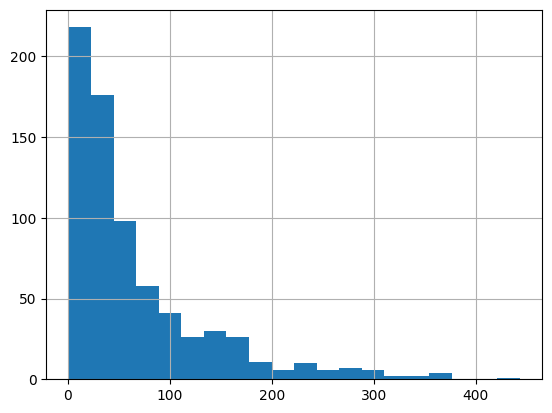

In [45]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [46]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [47]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [48]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
existing_cards['age'] = existing_cards['age'] * -1


existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 728
Total card age: 48409.62


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
721,Audit Report Tracker (Sharepoint List),List Items Endpoint (for retrieving items in a...,ab53dedb8adaa3ad12a6afcdb2e1dd65,-90.211120,56.621756,-90.211120,396.352290,0.246783,7,90.211120
722,Audit Report Tracker (Sharepoint List),Graph Explorer\nDefinition: A tool provided by...,ce03a3830816aa7288446e54b9961462,-81.680628,56.621756,-90.211120,396.352290,0.246783,7,90.211120
723,Audit Report Tracker (Sharepoint List),Content Type (SharePoint)\nDefinition: A reusa...,550cbe9de496b31e34c1526cce280209,-70.656610,56.621756,-90.211120,396.352290,0.246783,7,90.211120
724,Audit Report Tracker (Sharepoint List),Create List Item (for creating a new item in a...,61d7bf9689faf362a08adcf9ed49e29e,-68.141474,56.621756,-90.211120,396.352290,0.246783,7,90.211120
725,Audit Report Tracker (Sharepoint List),Content Type\nDefinition: A feature in SharePo...,512538c2ff0a894ffcd91c2a9a6de6b5,-39.805147,56.621756,-90.211120,396.352290,0.246783,7,90.211120
726,Audit Report Tracker (Sharepoint List),List Views Endpoint (for getting views in a Sh...,7370759495aae82439b5f4f2e070c0a7,-24.190652,56.621756,-90.211120,396.352290,0.246783,7,90.211120
727,Audit Report Tracker (Sharepoint List),List Administrator\nDefinition: A user with pe...,c04d54d96d16dfd514a229d890d7b6b4,-21.666659,56.621756,-90.211120,396.352290,0.246783,7,90.211120
576,Email Auth and Security,p=none\n\nA DMARC policy action.\nRequests no ...,98ed919f7e08cbf83347817d193116c3,-256.071317,100.616060,-256.071317,1207.392715,0.439327,12,256.071317
577,Email Auth and Security,Aggregate Reports\n\nSummary reports sent peri...,5c80cfa8657de0475b8c8f4c5cf6a911,-232.319483,100.616060,-256.071317,1207.392715,0.439327,12,256.071317
578,Email Auth and Security,SPF (Sender Policy Framework)\n\nA DNS-based e...,2c5dd2435fcdbaf7e688b35a78d91e32,-225.544639,100.616060,-256.071317,1207.392715,0.439327,12,256.071317


## Headers with greatest age sum first

In [49]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [50]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [51]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [52]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [53]:
# n=10
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [54]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [55]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [56]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [57]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [61]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
456,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-442.759018,85.084499,-442.759018,1786.774489,0.304104,21,442.759018
218,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-375.922783,74.133904,-375.922783,4448.034219,0.043258,60,375.922783
278,Python,Q:\nWhat happens if you try to call gen.next()...,a56125c87641d3bb052be7366138b43a,-370.931170,96.950722,-370.931170,3587.176709,0.805976,37,370.931170
457,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-363.155152,85.084499,-442.759018,1786.774489,0.304104,21,442.759018
477,Debugging in VS Code,"1. Debugger\nA tool used to inspect, control, ...",e5f2354be4982ffd49ff5162d37e9a30,-359.907168,92.810502,-359.907168,1577.778532,0.172095,17,359.907168
279,Python,Q:\nWhat are the two essential methods that an...,558bcbe4e40c504fe6e977eb903fb48d,-342.966221,96.950722,-370.931170,3587.176709,0.805976,37,370.931170
219,PnP PowerShell,System.IO.Stream (System.IO)\nRepresents a seq...,3f146f4a53f3f36ced6256f3cfc16375,-337.783813,74.133904,-375.922783,4448.034219,0.043258,60,375.922783
157,Azure Developer Associate,Where do Application Insights telemetry tables...,d5a8469fce507684c17e1dc224588031,-324.579513,86.371894,-324.579513,5268.685505,0.065427,61,324.579513
0,JavaScript Concepts,GraphQL: A query language for APIs that allows...,7e7b34d3208558b7ef2938d10bb39b64,-317.292437,89.150060,-317.292437,4100.902741,0.297278,46,317.292437
158,Azure Developer Associate,Why choose Azure Container Apps instead of Azu...,8c3d7ea082d3ab09d66623077af2f1b9,-309.428848,86.371894,-324.579513,5268.685505,0.065427,61,324.579513


In [59]:
existing_cards.head(10).sum()

head                   Audit Report Tracker (Sharepoint List)Audit Re...
body                   List Items Endpoint (for retrieving items in a...
hash                   ab53dedb8adaa3ad12a6afcdb2e1dd65ce03a3830816aa...
age                                                         -1110.287729
subject_mean_age                                              698.200468
subject_highest_age                                         -1399.691794
subject_age_sum                                              6396.644173
head_random_roll                                                3.045466
frequency                                                             85
oldest                                                       1399.691794
dtype: object

In [60]:
existing_cards['age'].mean()

-66.49673582956396